In [4]:
!pip install pandas matplotlib seaborn

  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)


In [6]:
# to say to jupyter notebook to plot/show the charts on it 
%matplotlib inline 
import pandas as pd # data frames
import numpy as np # matrix algebra
from matplotlib import pyplot as plt # normal charts
import seaborn as sns # fancy charts

# Regression

## Organize data

### Load data

In [7]:
# read data
df = pd.read_csv("https://raw.githubusercontent.com/askoshiyama/mli-cohort/master/boston.csv")
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,T1
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [8]:
# defining vars
input_vars = ["V1", "V2", "V3", "V4", "V5", "V6", "V7",
              "V8", "V9", "V10", "V11", "V12", "V13"]
output_var = ["T1"]

# dictionary of variables
pd.read_table("https://raw.githubusercontent.com/askoshiyama/mli-cohort3/master/Boston%20-%20Dictionary%20of%20Variables.txt")

,There are 14 attributes in each case of the dataset. They are:
0,V1 - CRIM - per capita crime rate by town
1,V2 - ZN - proportion of residential land zoned...
2,V3 - INDUS - proportion of non-retail business...
3,V4 - CHAS - Charles River dummy variable (1 if...
4,V5 - NOX - nitric oxides concentration (parts ...
5,V6 - RM - average number of rooms per dwelling
6,V7 - AGE - proportion of owner-occupied units ...
7,V8 - DIS - weighted distances to five Boston e...
8,V9 - RAD - index of accessibility to radial hi...
9,V10 - TAX - full-value property-tax rate per $...


### Some "integrity" checkings

In [9]:
df.dtypes

V1     float64
V2     float64
V3     float64
V4       int64
V5     float64
V6     float64
V7     float64
V8     float64
V9       int64
V10      int64
V11    float64
V12    float64
V13    float64
T1     float64
dtype: object

In [10]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,T1
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [12]:
df.corr().loc[output_var]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,T1
T1,-0.388305,0.360445,-0.483725,0.17526,-0.427321,0.69536,-0.376955,0.249929,-0.381626,-0.468536,-0.507787,0.333461,-0.737663,1.0


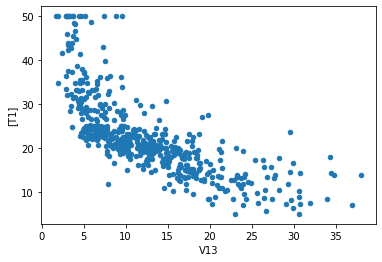

In [14]:
df.plot(y=output_var, x="V13", kind="scatter")

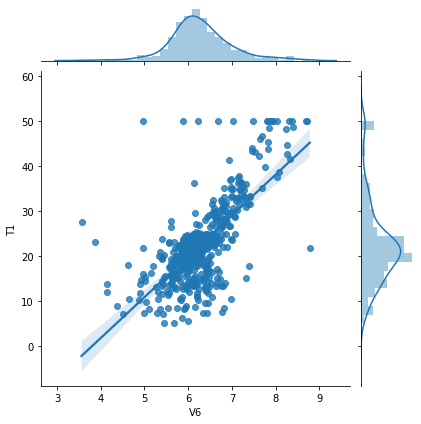

In [15]:
sns.jointplot(df["V6"], df["T1"], kind="reg")

## Modelling

### Settings

In [18]:
from sklearn import metrics
from sklearn.model_selection import KFold

# 5-fold cv
k_folds = KFold(n_splits=5, random_state=10, shuffle=True)

# performance metrics
# homework: https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics
def mse_score(y_true, y_pred):
    return np.mean( (y_true - y_pred) ** 2.0)

def rmse_score(y_true, y_pred):
    return np.sqrt(mse_score(y_true, y_pred))

def mad_score(y_true, y_pred):
    return np.mean( np.abs(y_true - y_pred) )

def pr2_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2.0

def adjpr2_score(y_true, y_pred, p):
    return ( np.corrcoef(y_true, y_pred)[0, 1] ** 2.0 ) * ((y_true.shape[0] - p)/y_true.shape[0])

perf_metrics = {"MSE": mse_score, 
                "RMSE": rmse_score, 
                "Pseudo-R2": pr2_score,
                "MAD": mad_score
               }

### Dummy/Baseline Model - Average

In [37]:
y_test_pred.shape

(101,)

In [38]:
# pre-instantiation
target = ["T1"]
df_metrics = pd.DataFrame(index=[0], columns=["Fold", "Metric", "Train", "Test"])

# main loop
k, f = 0, 0
for (train, test) in k_folds.split(df.drop(labels=target, axis=1)):
    f += 1
    print(f)
    # separate variables and folds
    x_train = df.drop(labels=target, axis=1).values[train]
    x_test = df.drop(labels=target, axis=1).values[test]
    y_train = df[target].values[train]
    y_test = df[target].values[test]
    
    # "fit" model
    model_pred = y_train.mean()

    # get predictions
    y_train_pred = np.repeat(model_pred, y_train.shape[0])
    y_test_pred = np.repeat(model_pred, y_test.shape[0])

    # compute metrics
    for pf in list(perf_metrics.keys()):
        df_metrics.loc[k, "Fold"] = f
        df_metrics.loc[k, "Metric"] = pf
        df_metrics.loc[k, "Train"] = perf_metrics[pf](y_train.ravel(), y_train_pred.ravel())
        df_metrics.loc[k, "Test"] = perf_metrics[pf](y_test.ravel(), y_test_pred.ravel())
        k += 1
        
    # if using sklearn: from from sklearn.dummy import DummyRegressor
    #ml = DummyRegressor().fit(x_train, y_train)
    #pred_train = ml.predict(x_train)
    #pred_test = ml.predict(x_test)

# final organization
df_metrics = df_metrics.apply(pd.to_numeric, errors="ignore")

1
2
3
4
5


C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [39]:
df_metrics

,Fold,Metric,Train,Test
0,1,MSE,7.696085e+01,1.163304e+02
1,1,RMSE,8.772733e+00,1.078566e+01
2,1,Pseudo-R2,5.041780e-32,1.616821e-32
3,1,MAD,6.303904e+00,7.554703e+00
4,2,MSE,8.777292e+01,7.147500e+01
5,2,RMSE,9.368720e+00,8.454289e+00
6,2,Pseudo-R2,NaN,2.013598e-32
7,2,MAD,6.773327e+00,6.451827e+00
8,3,MSE,8.261540e+01,9.174415e+01
9,3,RMSE,9.089301e+00,9.578317e+00


In [40]:
df_metrics.pivot_table(index="Metric", aggfunc="mean")

,Fold,Test,Train
Metric,,,
MAD,3,6.705918e+00,6.643009e+00
MSE,3,8.561962e+01,8.427595e+01
Pseudo-R2,3,4.218032e-32,2.711646e-32
RMSE,3,9.210837e+00,9.177422e+00


### Simple Linear Regression

In [44]:
# pre-instantiation
target = ["T1"]
df_metrics = pd.DataFrame(index=[0], columns=["Fold", "Metric", "Train", "Test"])

# main loop
k, f = 0, 0
for (train, test) in k_folds.split(df.drop(labels=target, axis=1)):
    f += 1
    print(f)
    # separate variables and folds
    x_train = df.drop(labels=target, axis=1).values[train]
    x_train = np.hstack([np.ones((x_train.shape[0], 1)), x_train])
    
    x_test = df.drop(labels=target, axis=1).values[test]
    x_test = np.hstack([np.ones((x_test.shape[0], 1)), x_test])
    
    y_train = df[target].values[train]
    y_test = df[target].values[test]
    
    # fit model
    # train model - coefs = (X_train'X_train)^-1 X_train'y_train
    inv_component = np.linalg.pinv(np.matmul(x_train.transpose(), x_train))
    coefs = np.matmul(inv_component, np.matmul(x_train.transpose(), y_train))

    # get predictions
    y_train_pred = np.matmul(x_train, coefs) # X_train*coefs
    y_test_pred = np.matmul(x_test, coefs) # X_train*coefs

    # compute metrics
    for pf in list(perf_metrics.keys()):
        df_metrics.loc[k, "Fold"] = f
        df_metrics.loc[k, "Metric"] = pf
        df_metrics.loc[k, "Train"] = perf_metrics[pf](y_train.ravel(), y_train_pred.ravel())
        df_metrics.loc[k, "Test"] = perf_metrics[pf](y_test.ravel(), y_test_pred.ravel())
        k += 1
        
    # if using sklearn: from sklearn.linear_model import LinearRegression
    #ml = LinearRegression().fit(x_train, y_train)
    #pred_train = ml.predict(x_train)
    #pred_test = ml.predict(x_test)

# final organization
df_metrics = df_metrics.apply(pd.to_numeric, errors="ignore")

1
2
3
4
5


#### Stats

In [45]:
df_metrics.pivot_table(index="Metric")

,Fold,Test,Train
Metric,,,
MAD,3,3.415622,3.264779
MSE,3,23.937804,21.667789
Pseudo-R2,3,0.716386,0.742878
RMSE,3,4.858078,4.652427


### Linear Regression with Polynomial Features

In [61]:
from sklearn.preprocessing import PolynomialFeatures
poly_params = {"degree": 2,
               "interaction_only": False,
               "include_bias": True
              }

In [57]:
x_train.shape

(405, 105)

In [48]:
poly_func = PolynomialFeatures(**poly_params).fit(df.drop(labels=target, axis=1))
x_train = poly_func.transform(df.drop(labels=target, axis=1))

In [49]:
x_train.shape

(506, 105)

In [53]:
x_test.shape

(101, 105)

In [62]:
# pre-instantiation
target = ["T1"]
df_metrics = pd.DataFrame(index=[0], columns=["Fold", "Metric", "Train", "Test"])

# main loop
k, f = 0, 0
for (train, test) in k_folds.split(df.drop(labels=target, axis=1)):
    f += 1
    print(f)
    # separate variables and folds
    x_train = df.drop(labels=target, axis=1).values[train]
    x_test = df.drop(labels=target, axis=1).values[test]
    y_train = df[target].values[train]
    y_test = df[target].values[test]
    
    # polynomial features - will include bias automatically
    poly_func = PolynomialFeatures(**poly_params).fit(x_train)
    x_train = poly_func.transform(x_train)
    x_test = poly_func.transform(x_test)
        
    # fit model
    # train model 
    inv_component = np.linalg.pinv(np.matmul(x_train.transpose(), x_train))
    coefs = np.matmul(inv_component, np.matmul(x_train.transpose(), y_train))

    # get predictions
    y_train_pred = np.matmul(x_train, coefs)
    y_test_pred = np.matmul(x_test, coefs)

    # compute metrics
    for pf in list(perf_metrics.keys()):
        df_metrics.loc[k, "Fold"] = f
        df_metrics.loc[k, "Metric"] = pf
        df_metrics.loc[k, "Train"] = perf_metrics[pf](y_train.ravel(), y_train_pred.ravel())
        df_metrics.loc[k, "Test"] = perf_metrics[pf](y_test.ravel(), y_test_pred.ravel())
        k += 1

    # if using sklearn: from sklearn.linear_model import LinearRegression
    #ml = LinearRegression().fit(x_train, y_train)
    #pred_train = ml.predict(x_train)
    #pred_test = ml.predict(x_test)

# final organization
df_metrics = df_metrics.apply(pd.to_numeric, errors="ignore")

1
2
3
4
5


In [63]:
df_metrics.pivot_table(index="Metric")

,Fold,Test,Train
Metric,,,
MAD,3,2.660769,1.767849
MSE,3,15.883051,5.707234
Pseudo-R2,3,0.823727,0.932166
RMSE,3,3.956649,2.385393


### Polynomial Regression with Backward Elimination

In [60]:
# pre-instantiation
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
poly_params = {"degree": 2,
               "interaction_only": False,
               "include_bias": True
              }
target = ["T1"]
df_metrics = pd.DataFrame(index=[0], columns=["Fold", "Metric", "Train", "Test"])

# main loop
k, f = 0, 0
for (train, test) in k_folds.split(df.drop(labels=target, axis=1)):
    f += 1
    print(f)
    # separate variables and folds
    x_train = df.drop(labels=target, axis=1).values[train]
    x_test = df.drop(labels=target, axis=1).values[test]
    y_train = df[target].values[train]
    y_test = df[target].values[test]
    
    # polynomial features - will include bias automatically
    poly_func = PolynomialFeatures(**poly_params).fit(x_train)
    x_train = poly_func.transform(x_train)
    x_test = poly_func.transform(x_test)
        
    # fit model
    model = LinearRegression()
    model = RFECV(model, step=1, cv=5).fit(x_train, y_train)

    # get predictions
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # compute metrics
    for pf in list(perf_metrics.keys()):
        df_metrics.loc[k, "Fold"] = f
        df_metrics.loc[k, "Metric"] = pf
        df_metrics.loc[k, "Train"] = perf_metrics[pf](y_train.ravel(), y_train_pred.ravel())
        df_metrics.loc[k, "Test"] = perf_metrics[pf](y_test.ravel(), y_test_pred.ravel())
        k += 1

# final organization
df_metrics = df_metrics.apply(pd.to_numeric, errors="ignore")

1


C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2


C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3


C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


4


C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


5


C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
df_metrics.pivot_table(index="Metric")

,Fold,Test,Train
Metric,,,
MAD,3,3.917123,3.778212
MSE,3,33.120635,31.232379
Pseudo-R2,3,0.594257,0.631558
RMSE,3,5.700084,5.444833


#### Different implementation

In [25]:
# pre-instantiation
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
poly_params = {"degree": 2,
               "interaction_only": False,
               "include_bias": True
              }
target = ["T1"]
df_metrics = pd.DataFrame(index=[0], columns=["Fold", "Metric", "Train", "Test"])

# main loop
k, f = 0, 0
for (train, test) in k_folds.split(df.drop(labels=target, axis=1)):
    f += 1
    print(f)
    # separate variables and folds
    x_train = df.drop(labels=target, axis=1).values[train]
    x_test = df.drop(labels=target, axis=1).values[test]
    y_train = df[target].values[train]
    y_test = df[target].values[test]
        
    # fit model
    model = Pipeline([("Poly", PolynomialFeatures(**poly_params)),
                      ("LR-BE", RFE(LinearRegression()))])
    model.fit(x_train, y_train)

    # get predictions
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # compute metrics
    for pf in list(perf_metrics.keys()):
        df_metrics.loc[k, "Fold"] = f
        df_metrics.loc[k, "Metric"] = pf
        df_metrics.loc[k, "Train"] = perf_metrics[pf](y_train.ravel(), y_train_pred.ravel())
        df_metrics.loc[k, "Test"] = perf_metrics[pf](y_test.ravel(), y_test_pred.ravel())
        k += 1

# final organization
df_metrics = df_metrics.apply(pd.to_numeric, errors="ignore")

1
2

C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3
4


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


5


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
df_metrics.pivot_table(index="Metric")

,Fold,Test,Train
Metric,,,
MAD,3,2.838603,2.182663
MSE,3,17.365153,9.229617
Pseudo-R2,3,0.797588,0.890918
RMSE,3,4.125922,3.024802


### Ridge Regression

In [76]:
pd.DataFrame(scaler_x.transform(df.drop(labels=target, axis=1).values[train])).mean()

0     6.017135e-17
1     2.875615e-16
2     3.441828e-15
3     5.570304e-16
4    -1.236446e-14
5    -1.233047e-14
6    -2.110794e-16
7     1.409846e-15
8     6.387209e-16
9    -5.071389e-16
10    3.209723e-14
11    7.631344e-15
12   -3.933753e-16
dtype: float64

In [86]:
from sklearn.preprocessing import StandardScaler
# pre-instantiation
ridge_shrinkage = np.linspace(0.00001, 0.4, num=200)
target = ["T1"]
df_metrics = pd.DataFrame(index=[0], columns=["Fold", "Shrinkage", "Metric", "Train", "Test"])

# main loop
k, f = 0, 0
for (train, test) in k_folds.split(df.drop(labels=target, axis=1)):
    f += 1
    print(f)
    # separate variables and folds
    x_train = df.drop(labels=target, axis=1).values[train]
    x_test = df.drop(labels=target, axis=1).values[test]
    y_train = df[target].values[train]
    y_test = df[target].values[test]
    
    # scale  variables
    scaler_x = StandardScaler(with_mean=True, with_std=True).fit(x_train)
    x_train = np.hstack([np.ones((x_train.shape[0], 1)), scaler_x.transform(x_train)])
    x_test = np.hstack([np.ones((x_test.shape[0], 1)), scaler_x.transform(x_test)])
    
    # fit model
    for l in ridge_shrinkage:
        # train model - coefs = (X'X + I * \lambda * p)^-1 X'y
        inv_component = np.linalg.pinv(np.matmul(x_train.transpose(), x_train) + np.eye(x_train.shape[1]) * l * x_train.shape[1])
        coefs = np.matmul(inv_component, np.matmul(x_train.transpose(), y_train))
        
        # get predictions
        y_train_pred = np.matmul(x_train, coefs) # X * coefs
        y_test_pred = np.matmul(x_test, coefs)
        
        # compute metrics
        for pf in list(perf_metrics.keys()):
            df_metrics.loc[k, "Fold"] = f
            df_metrics.loc[k, "Metric"] = pf
            df_metrics.loc[k, "Shrinkage"] = l
            df_metrics.loc[k, "Train"] = perf_metrics[pf](y_train.ravel(), y_train_pred.ravel())
            df_metrics.loc[k, "Test"] = perf_metrics[pf](y_test.ravel(), y_test_pred.ravel())
            k += 1
        
        # if using sklearn: from sklearn.linear_model import Ridge
        #ml = Ridge(alpha=l).fit(x_train, y_train)
        #pred_train = ml.predict(x_train)
        #pred_test = ml.predict(x_test)

# final organization
df_metrics = df_metrics.apply(pd.to_numeric, errors="ignore")

1
2
3
4
5


#### Stats

In [87]:
df_metrics.pivot_table(index="Shrinkage", columns="Metric", values="Test").head()

Metric,MAD,MSE,Pseudo-R2,RMSE
Shrinkage,,,,
0.00001,3.415620,23.937802,0.716386,4.858077
0.00202,3.415227,23.937523,0.716387,4.858034
0.00403,3.414838,23.937251,0.716389,4.857992
0.00604,3.414450,23.936987,0.716391,4.857951
0.00805,3.414062,23.936731,0.716392,4.857910


In [88]:
df_agg_metrics = df_metrics.pivot_table(index="Shrinkage", columns="Metric", values="Test")

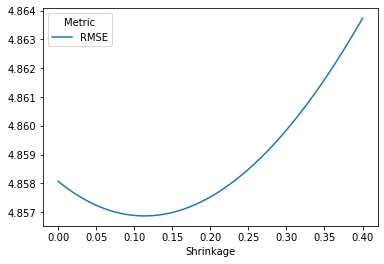

In [89]:
df_agg_metrics[["RMSE"]].plot()

In [90]:
df_agg_metrics.loc[df_agg_metrics["RMSE"].idxmin()]

Metric
MAD           3.395047
MSE          23.933826
Pseudo-R2     0.716442
RMSE          4.856875
Name: 0.11257, dtype: float64

### Ridge + Polynomial Features

In [98]:
# pre-instantiation
poly_params = {"degree": 3,
               "interaction_only": False,
               "include_bias": True
              }
ridge_shrinkage = np.linspace(0.00001, 0.4, num=200)
target = ["T1"]
df_metrics = pd.DataFrame(index=[0], columns=["Fold", "Shrinkage", "Metric", "Train", "Test"])

# main loop
k, f = 0, 0
for (train, test) in k_folds.split(df.drop(labels=target, axis=1)):
    f += 1
    print(f)
    # separate variables and folds
    x_train = df.drop(labels=target, axis=1).values[train]
    x_test = df.drop(labels=target, axis=1).values[test]
    y_train = df[target].values[train]
    y_test = df[target].values[test]
        
    # scale variables
    scaler_x = StandardScaler().fit(x_train)
    x_train = scaler_x.transform(x_train)
    x_test = scaler_x.transform(x_test)
    
    # polynomial features - will include bias automatically
    poly_func = PolynomialFeatures(**poly_params).fit(x_train)
    x_train = poly_func.transform(x_train)
    x_test = poly_func.transform(x_test)
        
    # fit model
    for l in ridge_shrinkage:
        # train model - min ||coefs||^2, subject to: X coefs = y -- L(\lambda) = ||coefs||^1 + \lambda * (X coefs - y)
        inv_component = np.linalg.pinv(np.matmul(x_train.transpose(), x_train) + np.eye(x_train.shape[1]) * l * x_train.shape[1])
        coefs = np.matmul(inv_component, np.matmul(x_train.transpose(), y_train))
        
        # get predictions
        y_train_pred = np.matmul(x_train, coefs)
        y_test_pred = np.matmul(x_test, coefs)
        
        # compute metrics
        for pf in list(perf_metrics.keys()):
            df_metrics.loc[k, "Fold"] = f
            df_metrics.loc[k, "Metric"] = pf
            df_metrics.loc[k, "Shrinkage"] = l
            df_metrics.loc[k, "Train"] = perf_metrics[pf](y_train.ravel(), y_train_pred.ravel())
            df_metrics.loc[k, "Test"] = perf_metrics[pf](y_test.ravel(), y_test_pred.ravel())
            k += 1
        
        # if using sklearn: from sklearn.linear_model import Ridge, Lasso
        #ml = Ridge(alpha=l).fit(x_train, y_train)
        #pred_train = ml.predict(x_train)
        #pred_test = ml.predict(x_test)

# final organization
df_metrics = df_metrics.apply(pd.to_numeric, errors="ignore")

1
2
3
4
5


#### Stats

In [99]:
df_agg_metrics = df_metrics.pivot_table(index="Shrinkage", columns="Metric", values="Test")

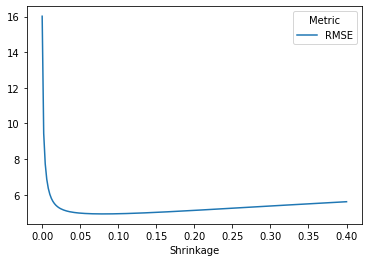

In [100]:
df_agg_metrics[["RMSE"]].plot()

In [101]:
df_agg_metrics.loc[df_agg_metrics["RMSE"].idxmin()]

Metric
MAD           3.351592
MSE          24.837005
Pseudo-R2     0.754024
RMSE          4.918897
Name: 0.08041, dtype: float64

# Classification

## Organize data

### Load data

In [102]:
df = pd.read_csv("https://raw.githubusercontent.com/askoshiyama/mli-cohort/master/german_credit.csv")
df.head()

,default,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,0,< 0 DM,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male : single,...,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,...,2,real estate,22,none,own,1,skilled employee / official,1,none,yes
2,0,no checking account,12,critical account/ other credits existing (not ...,(vacation - does not exist?),2096,... < 100 DM,4 <= ... < 7 years,2,male : single,...,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,0,< 0 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,...,4,if not A121 : building society savings agreeme...,45,none,for free,1,skilled employee / official,2,none,yes
4,1,< 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,...,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes


### Pre-process variables

In [37]:
# variable types
df.dtypes

default                        int64
account_check_status          object
duration_in_month              int64
credit_history                object
purpose                       object
credit_amount                  int64
savings                       object
present_emp_since             object
installment_as_income_perc     int64
personal_status_sex           object
other_debtors                 object
present_res_since              int64
property                      object
age                            int64
other_installment_plans       object
housing                       object
credits_this_bank              int64
job                           object
people_under_maintenance       int64
telephone                     object
foreign_worker                object
dtype: object

In [38]:
# categorical variables
cat_variables = ['account_check_status', 'credit_history', 'purpose', 'savings', 'present_emp_since', 'personal_status_sex',
                'property', 'other_installment_plans', 'housing', 'job', 'telephone', "other_debtors", 'foreign_worker']

# target variable
output_variable = ["default"]

# other integer variables
int_variables = ['credits_this_bank', 'present_res_since', 'duration_in_month', 'people_under_maintenance', 
                 'installment_as_income_perc', 'age', 'credit_amount']
# list(set(df.columns) - set(output_variable) - set(cat_variables))

In [39]:
# pre-allocation
df_cat = pd.DataFrame(index=df.index)

# one-hot encoding of categorical variables
from sklearn.preprocessing import OneHotEncoder

# I will do a loop for pedagogical reasons, but it is not entirely necessary
for cat in cat_variables:
    # one-hot encoding fitting
    one_hot_func = OneHotEncoder().fit(df[[cat]])
    
    # mapping
    cat_mapped = one_hot_func.transform(df[[cat]]).toarray()
    
    # storing
    for (k, cat_label) in enumerate(one_hot_func.categories_[0]):
        df_cat[cat + "_" + cat_label] = cat_mapped[:, k]

# quick check
df_cat.mean()

account_check_status_0 <= ... < 200 DM                                        0.269
account_check_status_< 0 DM                                                   0.274
account_check_status_>= 200 DM / salary assignments for at least 1 year       0.063
account_check_status_no checking account                                      0.394
credit_history_all credits at this bank paid back duly                        0.049
credit_history_critical account/ other credits existing (not at this bank)    0.293
credit_history_delay in paying off in the past                                0.088
credit_history_existing credits paid back duly till now                       0.530
credit_history_no credits taken/ all credits paid back duly                   0.040
purpose_(vacation - does not exist?)                                          0.050
purpose_business                                                              0.097
purpose_car (new)                                                           

In [40]:
# bracketing integer variable - age
from sklearn.preprocessing import KBinsDiscretizer
kbin_func = KBinsDiscretizer(n_bins=3, encode='onehot', strategy='quantile').fit(df[["age"]])
df_age = pd.DataFrame(kbin_func.transform(df[["age"]]).toarray(), columns=["young", "adult", "senior"])

# checking
pd.concat([df_age, df[["age"]]], axis=1).head(10)

,young,adult,senior,age
0,0.0,0.0,1.0,67
1,1.0,0.0,0.0,22
2,0.0,0.0,1.0,49
3,0.0,0.0,1.0,45
4,0.0,0.0,1.0,53
5,0.0,1.0,0.0,35
6,0.0,0.0,1.0,53
7,0.0,1.0,0.0,35
8,0.0,0.0,1.0,61
9,0.0,1.0,0.0,28


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


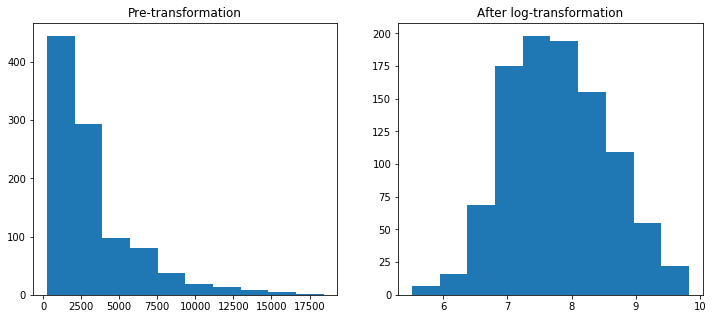

In [41]:
# other types of transformations possible - log transformation 
from sklearn.preprocessing import FunctionTransformer
log_mapping = FunctionTransformer(func=np.log, inverse_func=np.exp)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.hist(df["credit_amount"])
ax1.set_title("Pre-transformation")

ax2.hist(log_mapping.transform(df[["credit_amount"]]))
ax2.set_title("After log-transformation")
df_log = pd.DataFrame(log_mapping.transform(df[["credit_amount"]]), columns=["log(credit)"])

### Consolidating a final dataset

In [42]:
df_model = pd.concat([df[int_variables[:-2]], df_cat, df_age, df_log, df[output_variable]], axis=1)
df.shape, df_model.shape

((1000, 21), (1000, 64))

In [43]:
df_model.head()

,credits_this_bank,present_res_since,duration_in_month,people_under_maintenance,installment_as_income_perc,account_check_status_0 <= ... < 200 DM,account_check_status_< 0 DM,account_check_status_>= 200 DM / salary assignments for at least 1 year,account_check_status_no checking account,credit_history_all credits at this bank paid back duly,...,other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,foreign_worker_no,foreign_worker_yes,young,adult,senior,log(credit),default
0,2,4,6,1,4,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,7.063904,0
1,1,2,48,1,2,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,8.691315,1
2,1,3,12,2,2,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,7.647786,0
3,1,4,42,2,2,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,8.972337,0
4,2,4,24,2,3,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,8.490849,1


## Modelling

In [44]:
df_model[output_variable].describe()

,default
count,1000.000000
mean,0.300000
std,0.458487
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


### Settings

In [45]:
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

# 3-fold cv
k_folds = StratifiedKFold(n_splits=3, random_state=10)

# performance metrics - 
# homework: https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
# homework: https://en.wikipedia.org/wiki/Confusion_matrix, 
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score,
                "AUC": metrics.roc_auc_score, 
                "F1-Score": metrics.f1_score, 
                "Brier": metrics.brier_score_loss}

### Logistic Regression - From "Scratch"

In [46]:
# some functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_prediction(X, theta):
    z = np.dot(X, theta)
    h = sigmoid(z)
    return h

def loss(h, y):
    h = np.clip(h, 1e-15, 1 - 1e-15) # too close to zero or one
    return -(y * np.log(h) + (1 - y) * np.log(1 - h)).mean()

In [47]:
# quick test
theta = np.random.normal(size=df_model.drop(labels=output_variable, axis=1).shape[1])
pred = logistic_prediction(df_model.drop(labels=output_variable, axis=1).values, theta)
loss(pred, df_model[output_variable].values)

4.960148729365081

In [48]:
# main loop
# pre-instantiation
n_vars = df_model.drop(labels=output_variable, axis=1).shape[1] # number of variables
step_size = 0.01 # finite difference step-size
lr = 0.01 # learning rate -- dictate the speed
max_iter = 30 # maximum number of iterations
df_metrics = pd.DataFrame(index=[0], columns=["Fold", "Metric", "Train", "Test"])

# main loop
k, f = 0, 0
for (train, test) in k_folds.split(df_model.drop(labels=output_variable, axis=1), df_model[output_variable]):
    f += 1
    # separate variables and folds
    x_train = df_model.drop(labels=output_variable, axis=1).values[train]
    x_test = df_model.drop(labels=output_variable, axis=1).values[test]
    y_train = df_model[output_variable].values[train]
    y_test = df_model[output_variable].values[test]
    
    # scale variables
    #scaler_x = StandardScaler().fit(x_train)
    #x_train = np.hstack([np.ones((x_train.shape[0], 1)), scaler_x.transform(x_train)])
    #x_test = np.hstack([np.ones((x_test.shape[0], 1)), scaler_x.transform(x_test)])
    
    # fit model
    # initialization
    theta = np.random.normal(size=n_vars) # random coefs
    pred = logistic_prediction(x_train, theta)
    loss_iter = loss(pred, y_train)
    print("fold: %d, iter: %d, loss: %.4f" % (f, 0, loss_iter), end="\r")
    
    # training
    for it in range(1, max_iter):
        log_grad = np.zeros(shape=(n_vars,))
        # compute numerical gradient - finite differences
        for c in range(n_vars):
            new_theta = np.copy(theta)
            new_theta[c] = new_theta[c] + step_size
            new_pred = logistic_prediction(x_train, new_theta)
            c_loss = loss(new_pred, y_train)
            log_grad[c] = (c_loss - loss_iter)/(step_size) # f'(x) ~ (f(x+e) - f(x-e))/2*e
        
        # update model
        theta = theta - lr * log_grad
        
        # get current loss
        pred = logistic_prediction(x_train, theta)
        diff_loss = np.abs(loss_iter - loss(pred, y_train))
        loss_iter = loss(pred, y_train)
        print("fold: %d, iter: %d, loss: %.4f, grad_norm: %.4f" % (f, it, loss_iter, np.linalg.norm(log_grad)), end="\r")
        if diff_loss < 1e-3:
            break
    
    # compute final predictions
    y_train_pred = logistic_prediction(x_train, theta)
    y_test_pred = logistic_prediction(x_test, theta)
    
    # store results
    for pf in list(perf_metrics.keys()):
        df_metrics.loc[k, "Fold"] = f
        df_metrics.loc[k, "Metric"] = pf
        if pf in ["Accuracy", "Precision", "Recall", "F1-Score"]: # put a threshold
            df_metrics.loc[k, "Train"] = perf_metrics[pf](y_train, y_train_pred > 0.5)
            df_metrics.loc[k, "Test"] = perf_metrics[pf](y_test, y_test_pred > 0.5)
        else:
            df_metrics.loc[k, "Train"] = perf_metrics[pf](y_train, y_train_pred)
            df_metrics.loc[k, "Test"] = perf_metrics[pf](y_test, y_test_pred)

        k += 1
        
        # if using sklearn: from sklearn.linear_model import Ridge
        #ml = LogisticRegression(penalty="None").fit(x_train, y_train)
        #y_train_pred = ml.predict(x_train)
        #y_test_pred = ml.predict(x_test)

# final organization
df_metrics = df_metrics.apply(pd.to_numeric, errors="ignore")

In [49]:
df_metrics.pivot_table(index="Metric", values=["Train", "Test"])

,Test,Train
Metric,,
AUC,0.420517,0.463256
Accuracy,0.436017,0.453990
Brier,0.521990,0.496362
F1-Score,0.290564,0.313519
Precision,0.238323,0.270101
Recall,0.480000,0.496667


### Sparse Logistic Regression (a.k.a. Ridge Logistic)

In [50]:
# pre-instantiation
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
shrink = np.linspace(0.001, 2.0, num=100)
df_metrics = pd.DataFrame(index=[0], columns=["Fold", "Shrinkage", "Metric", "Train", "Test"])

# main loop
k, f = 0, 0
for (train, test) in k_folds.split(df_model.drop(labels=output_variable, axis=1), df_model[output_variable]):
    f += 1
    # separate variables and folds
    x_train = df_model.drop(labels=output_variable, axis=1).values[train]
    x_test = df_model.drop(labels=output_variable, axis=1).values[test]
    y_train = df_model[output_variable].values[train]
    y_test = df_model[output_variable].values[test]
    
    # scale  variables
    scaler_x = StandardScaler().fit(x_train)
    x_train = scaler_x.transform(x_train)
    x_test = scaler_x.transform(x_test)
    
    # fit model
    for l in shrink:
        # train model
        model = LogisticRegression(penalty="l2", C=l, solver="lbfgs").fit(x_train, y_train.ravel())
        
        # get predictions
        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)
        
        # compute metrics
        for pf in list(perf_metrics.keys()):
            df_metrics.loc[k, "Fold"] = f
            df_metrics.loc[k, "Metric"] = pf
            df_metrics.loc[k, "Shrinkage"] = l
            if pf in ["Accuracy", "Precision", "Recall", "F1-Score"]: # put a threshold
                df_metrics.loc[k, "Train"] = perf_metrics[pf](y_train, y_train_pred > 0.5)
                df_metrics.loc[k, "Test"] = perf_metrics[pf](y_test, y_test_pred > 0.5)
            else:
                df_metrics.loc[k, "Train"] = perf_metrics[pf](y_train, y_train_pred)
                df_metrics.loc[k, "Test"] = perf_metrics[pf](y_test, y_test_pred)

            k += 1
    print("fold: %d" % (f))

# final organization
df_metrics = df_metrics.apply(pd.to_numeric, errors="ignore")

C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold: 1


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold: 2


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold: 3


In [51]:
df_metrics.pivot_table(index=["Shrinkage"], columns=["Metric"], values=["Test"]).head()

Test                                                  
Metric          AUC  Accuracy     Brier  F1-Score Precision    Recall
Shrinkage                                                            
0.001000   0.500000  0.699999  0.300001  0.000000  0.000000  0.000000
0.021192   0.656899  0.757006  0.242994  0.499760  0.651295  0.406667
0.041384   0.663804  0.756005  0.243995  0.513775  0.634921  0.433333
0.061576   0.663325  0.754000  0.246000  0.513731  0.628125  0.436667
0.081768   0.661421  0.749999  0.250001  0.511149  0.614515  0.440000

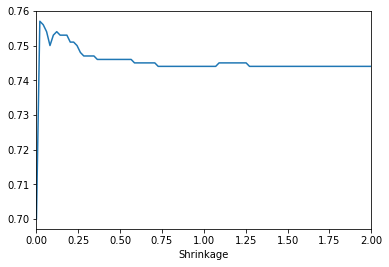

In [52]:
df_metrics.pivot_table(index=["Shrinkage"], columns=["Metric"], values=["Test"])["Test"]["Accuracy"].plot()